In [1]:
from finrl.finrl_meta.env_cryptocurrency_trading.env_multiple_crypto import CryptoEnv
from finrl.agents.elegantrl.models import DRLAgent as DRLAgent_erl
from finrl.finrl_meta.preprocessor.preprocessors import data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import datetime
from data_processor import config

import matplotlib


/home/henry/miniconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import ccxt
import pandas as pd
import numpy as np


## Read Doneloaded Data

In [3]:
tic_list = [
    "BNBUSDT",
    "BTCUSDT",
    "ETHUSDT",
]

interval = "2h"


In [4]:
df_list = []
for tic in tic_list:
    data_path = f"./data/{tic}-{interval}.csv"
    data = pd.read_csv(data_path).values
    df = pd.DataFrame(
        data,
        columns=[
            "date",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
    )
    df["date"] = pd.to_datetime(df["date"].add(1800000), unit="ms")
    df.drop(
        columns=[
            "close_time",
            "quote_asset_volume",
            "number_of_trades",
            "taker_buy_base_asset_volume",
            "taker_buy_quote_asset_volume",
            "ignore",
        ],
        inplace=True,
    )
    df["tic"] = tic
    df_list.append(df)

price_df = pd.concat(df_list)
price_df = price_df.sort_values(by=["date", "tic"], ignore_index=True)


In [5]:
from data_processor.indicator import add_tech_indicator

data_df = add_tech_indicator(price_df).dropna(how="any")
data_df.iloc[0]["date"]


Timestamp('2021-01-11 00:30:00')

In [6]:
data_df = data_df.drop(columns=["open", "high", "low"])


In [7]:
train = data_split(data_df, "2021-06-01", "2022-1-31")
trade = data_split(data_df, "2022-02-01", "2022-3-31")
print(len(train), len(trade))


8778 2088


In [10]:
train[train['tic'] == 'BTCUSDT']

,date,close,volume,tic,SMA_20,SMA_60,SMA_120,macdhist,CCI,RSI,NATR,ADOSC
0,2021-06-01 00:30:00,37196.64,8388.506891,BTCUSDT,36110.6925,36446.734167,36907.080333,194.290950,94.140076,60.914576,2.293346,670.190452
1,2021-06-01 02:30:00,36704.99,6258.551517,BTCUSDT,36127.9700,36431.458000,36905.023167,140.555927,43.574101,54.908907,2.317260,-1145.979018
2,2021-06-01 04:30:00,37266.55,4370.552793,BTCUSDT,36207.4545,36416.958167,36912.442333,133.412379,56.985032,59.785812,2.270374,-688.644332
3,2021-06-01 06:30:00,36831.58,5724.795040,BTCUSDT,36275.1835,36392.893333,36917.128167,91.945652,45.484933,54.838316,2.289219,-1387.646468
4,2021-06-01 08:30:00,36231.51,8530.677386,BTCUSDT,36295.7755,36342.127833,36909.275750,20.393716,-68.446191,48.834327,2.365424,-2539.681949
...,...,...,...,...,...,...,...,...,...,...,...,...
2921,2022-01-30 14:30:00,37980.09,1665.327300,BTCUSDT,37906.6280,37282.591000,36901.848750,-35.811541,-30.894568,54.331271,1.280665,319.750605
2922,2022-01-30 16:30:00,37991.00,1141.092080,BTCUSDT,37929.3895,37294.552167,36859.891667,-40.502930,-15.889303,54.498744,1.249584,584.981080
2923,2022-01-30 18:30:00,37512.37,2210.156590,BTCUSDT,37918.1215,37301.972833,36814.850417,-74.166374,-142.329565,46.450866,1.285167,107.078877
2924,2022-01-30 20:30:00,37729.00,1911.983080,BTCUSDT,37921.8855,37321.522167,36784.875083,-79.685341,-168.957746,50.046413,1.264322,410.721184


In [11]:
from my_trading_env.crypto_env import CryptoEnv
from my_trading_env.crypto_erl_agent import CryptoDRLAgent


In [12]:
env = CryptoEnv(data_df=train, tech_indicators_list=config.TECH_INDICATORS, lookback=20)


In [13]:
env.state_dim


544

## Auto-encoder

In [ ]:
import torch
import torch.nn as nn
from my_trading_env.auto_encoder import Autoencoder

auto_encoder = Autoencoder()

## .

In [11]:
agent = CryptoDRLAgent(env)


In [12]:
model_kwargs = {
    "learning_rate": 1e-5,
    "batch_size": 2**9,
    "gamma": 0.99,
    "seed": 312,
    "net_dimension": 2**12,
    "target_step": env.max_step * 2,
    "eval_gap": 50,
    "eval_times": 8,
}

model = agent.get_model("ppo_h", model_kwargs)


In [13]:
trained_model = agent.train_model(model=model, cwd="./test", total_timesteps=4e5)


| Arguments Remove cwd: ./test
################################################################################
ID     Step    maxR |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  8.66e+03    0.99 |
0  8.66e+03    0.99 |    0.99    0.0   2886     0 |   -0.04  69.03  -0.32  -0.50
0  3.46e+04    0.99 |    0.99    0.0   2886     0 |    0.00  62.85  -0.32  -0.50
0  6.06e+04    0.99 |    0.22    0.0   2886     0 |   -0.18  31.74  -0.32  -0.50
0  8.66e+04    0.99 |    0.07    0.0   2886     0 |   -0.04  47.94  -0.34  -0.50
0  1.04e+05    0.99 |    0.12    0.0   2886     0 |   -0.33  15.94  -0.26  -0.50
0  1.21e+05    0.99 |    0.04    0.0   2886     0 |   -0.31  11.96  -0.22  -0.50
0  1.39e+05    0.99 |    0.11    0.0   2886     0 |   -0.32  10.32  -0.28  -0.50
0  1.56e+05    0.99 |    0.95    0.0   2886     0 |   -0.04  43.88  -0.29  -0.50
0  1.73e+05    0.99 |    0.95    0.0   2886     0 |   -0.10  33.30  -0.31  -0.50
0  1.90e+05    0.99 |    0.95    0.0   2886     0 |   -0.04  30

## Backtest

In [22]:
test_env = CryptoEnv(trade, config.TECH_INDICATORS)
test_result, actions = agent.DRL_prediction(
    "ppo_h", "./test", model_kwargs["net_dimension"], test_env
)


Test Finished!
episode_return 1.1552326467921876


In [23]:
actions[0:2]


[array([1490.0273 ,  -57.39331, -343.1815 ], dtype=float32),
 array([10000.     ,    99.99996, -1000.     ], dtype=float32)]

In [30]:
baseline_df = pd.DataFrame()
baseline_df["account_value"] = trade[trade["tic"] == "BNBUSDT"]["close"].to_list()[1:]
baseline_df["date"] = test_result["date"]


In [31]:
trade_ret = get_daily_return(test_result)
base_ret = get_daily_return(baseline_df)


Start date,2022-02-01
End date,2022-03-30
Total months,33
,Backtest
Annual return,5.372%
Cumulative returns,15.523%
Annual volatility,16.238%
Sharpe ratio,0.40
Calmar ratio,0.22
Stability,0.00
Max drawdown,-24.325%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.32,2022-02-08,2022-02-24,2022-03-30,37
1,6.08,2022-02-01,2022-02-03,2022-02-04,3
2,4.26,2022-02-05,2022-02-06,2022-02-07,1
3,1.25,2022-03-30,2022-03-30,NaT,NaN
4,1.03,2022-02-07,2022-02-08,2022-02-08,1


Stress Events,mean,min,max
New Normal,0.03%,-6.66%,5.56%


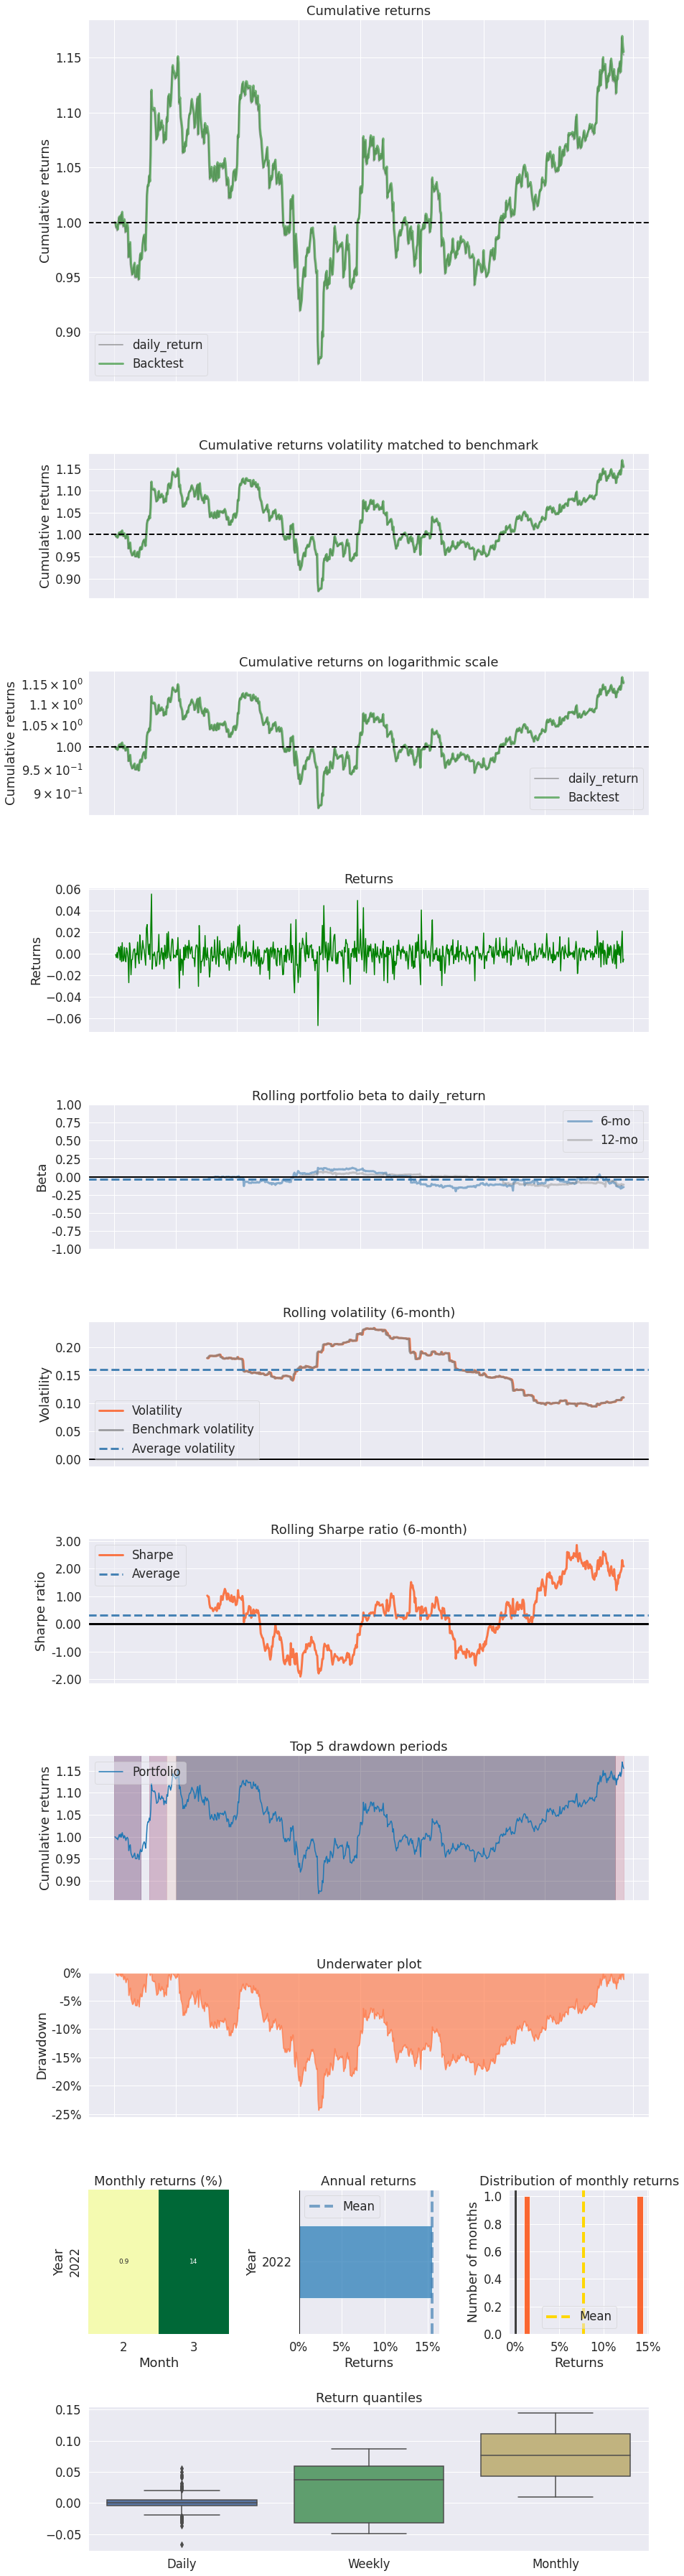

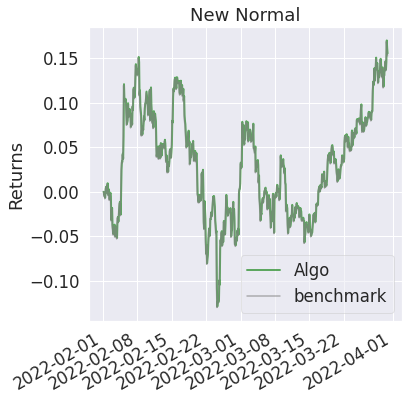

In [32]:
import pyfolio
%matplotlib inline

pyfolio.create_full_tear_sheet(trade_ret, benchmark_rets=base_ret)
# pyfolio.create_full_tear_sheet(trade_ret)